In [1]:
import pickle
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['lines.solid_capstyle'] = 'round'
mpl.rcParams['lines.solid_joinstyle'] = 'round'
mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Helvetica Neue') 
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 8})
from cmcrameri import cm

In [2]:
def running_mean(x, N, mode):
    
    '''
    Use np.convolve to return a running mean.

    Inputs
    --------
    X : Array of floats
        Values to compute running mean
    N : Int
        Window size of running mean
    mode : String
        Valid, full or same (see https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    for an example of the difference).
    
    Returns
    --------
    Array of values representing the running mean
    '''
    #x = np.pad(x, (0, N // 2), mode='constant', constant_values = np.nan)
    return np.convolve(x, np.ones((N,))/N, mode=mode)


def is_point_in_polygon(point, polygon):
    """
    Check if a point is within a polygon.

    Args:
        point (array-like): Coordinates of the point [x, y].
        polygon (array-like): Coordinates of the polygon vertices [[x1, y1], [x2, y2], ...].

    Returns:
        bool: True if the point is inside the polygon, False otherwise.
    """
    point = np.array(point)
    polygon = np.array(polygon)
    n_vertices = len(polygon)

    # Check if the point is on a vertex
    if any(np.all(point == vertex) for vertex in polygon):
        return True

    # Check if the point is inside the polygon using the ray casting algorithm
    is_inside = False
    for i in range(n_vertices):
        j = (i + 1) % n_vertices
        if ((polygon[i, 1] > point[1]) != (polygon[j, 1] > point[1])) and \
           (point[0] < (polygon[j, 0] - polygon[i, 0]) * (point[1] - polygon[i, 1]) /
           (polygon[j, 1] - polygon[i, 1]) + polygon[i, 0]):
            is_inside = not is_inside

    return is_inside

In [3]:
# Peridotite densities
perid_density_g_cm3 = 3.3 #g/cm3
perid_density_g_km3 = perid_density_g_cm3 * 100000**3
perid_density_g_m3 = perid_density_g_cm3 * 100**3
perid_density_kg_km3 = perid_density_g_km3 * 1e-3
perid_density_kg_m3 = perid_density_g_m3 * 1e-3

# make dictionary of results
results_dict = {}

In [4]:
# Load results
with open('./data/subduction_tracks_2022-09-14.pickle', 'rb') as f:
    tracks = pickle.load(f)

# Load antigorite stability curve
antigorite_df = pd.read_csv('./data/atg-out_reaction.csv')

# Get smoothed antigoriate bounds for plotting
window= 5
ant_rho_running_mean = running_mean(antigorite_df['P_[kbar]']/10, window, 'valid')
ant_temp_running_mean = running_mean(antigorite_df['T_[C]'], window, 'valid')

# Load processed results
df_results =  pd.read_csv('./results/PT_results_2022_Sep_v2.csv') #this is volume of perids


In [5]:
# All RAP
pressure_range = np.linspace(0,np.max(tracks['pressure_MODEL'].values),40)
temp_range = np.linspace(0,np.max(tracks['temp_SYR10_MODEL'].values),40)
all_RAP_pressure_steps = []
all_RAP_temp_steps = []
variables = []
for ind, (i,j) in enumerate(zip(temp_range, pressure_range)):
    if ind == len(temp_range)-1:
        break
    else:
        # Pressure
        start_pressure = pressure_range[ind]
        final_pressure = pressure_range[ind+1]
        all_RAP_pressure_steps.append(([start_pressure, final_pressure]))
        # Temp
        start_temp = temp_range[ind]
        final_temp = temp_range[ind+1]
        all_RAP_temp_steps.append(([start_temp, final_temp]))
        
all_RAP_pressure_steps = np.asarray(all_RAP_pressure_steps)
all_RAP_temp_steps = np.asarray(all_RAP_temp_steps)

/var/folders/gs/2q8t31qn5wjb02_tw8sm_c7h0000gn/T/ipykernel_98510/36426179.py:15: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(c, ax=ax)


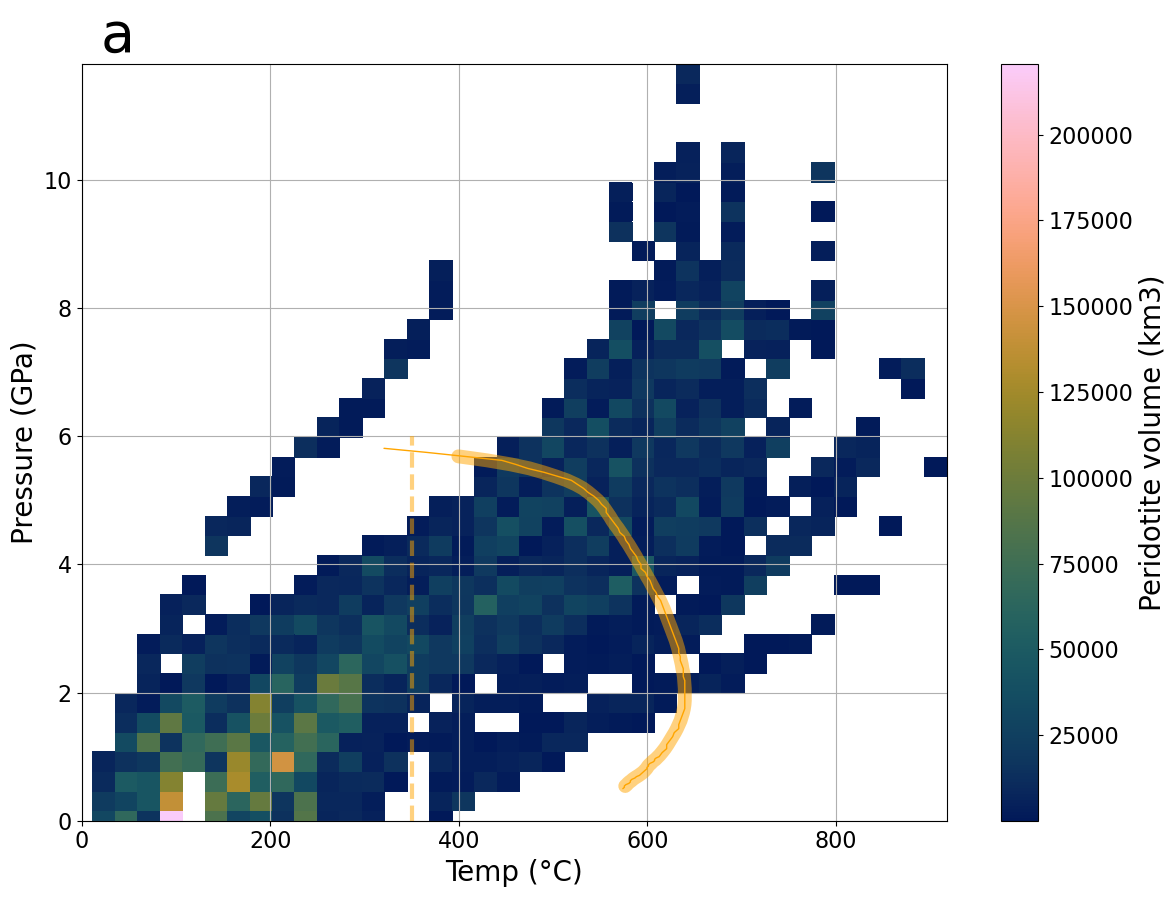

In [6]:
x, y = np.meshgrid(all_RAP_pressure_steps[:,0], all_RAP_temp_steps[:,0])
all_RAP_reshape = np.reshape(df_results['total_peridotite'].values, np.shape(y))
all_RAP_reshape[all_RAP_reshape == 0.0] = np.nan

fig, ax = plt.subplots(nrows=1, 
                       ncols=1,
                       figsize=(12,9))


#print ax

c = ax.pcolor(y, x, all_RAP_reshape, zorder=0, cmap=cm.batlow)
ax.set_ylabel('Pressure (GPa)', fontsize=20)
ax.set_xlabel('Temp (°C)', fontsize=20)
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('Peridotite volume (km3)', fontsize=20)
cbar.ax.tick_params(labelsize=16)
ax.plot(antigorite_df['T_[C]'],antigorite_df['P_[kbar]']/10, c='orange', lw=1)
ax.vlines(350, 0, 6, color='orange', lw=3, ls='--', alpha=0.5)
ax.plot(ant_temp_running_mean, ant_rho_running_mean, c='orange', lw=10, alpha=0.5)
ax.text(20, 12, 'a', fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlim(0)
ax.set_ylim(0)
ax.grid()
fig.tight_layout()

#fig.savefig('./figures/all_RAP_PT.pdf')

In [7]:

#get min and max presures of antigorite stability
min_ant_pressure = antigorite_df['P_[kbar]'].min()/10
max_ant_pressure = antigorite_df['P_[kbar]'].max()/10
min_ant_temp = antigorite_df['T_[C]'].min()
max_ant_temp = antigorite_df['T_[C]'].max()

print(min_ant_pressure, max_ant_pressure, min_ant_temp, max_ant_temp)

0.5 5.813000000000001 320.68 639.59


/var/folders/gs/2q8t31qn5wjb02_tw8sm_c7h0000gn/T/ipykernel_98510/1007551084.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(tracks['temp_SYR10_MODEL'],
/var/folders/gs/2q8t31qn5wjb02_tw8sm_c7h0000gn/T/ipykernel_98510/1007551084.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df_within_antigorite_model['temp_SYR10_MODEL'],
/var/folders/gs/2q8t31qn5wjb02_tw8sm_c7h0000gn/T/ipykernel_98510/1007551

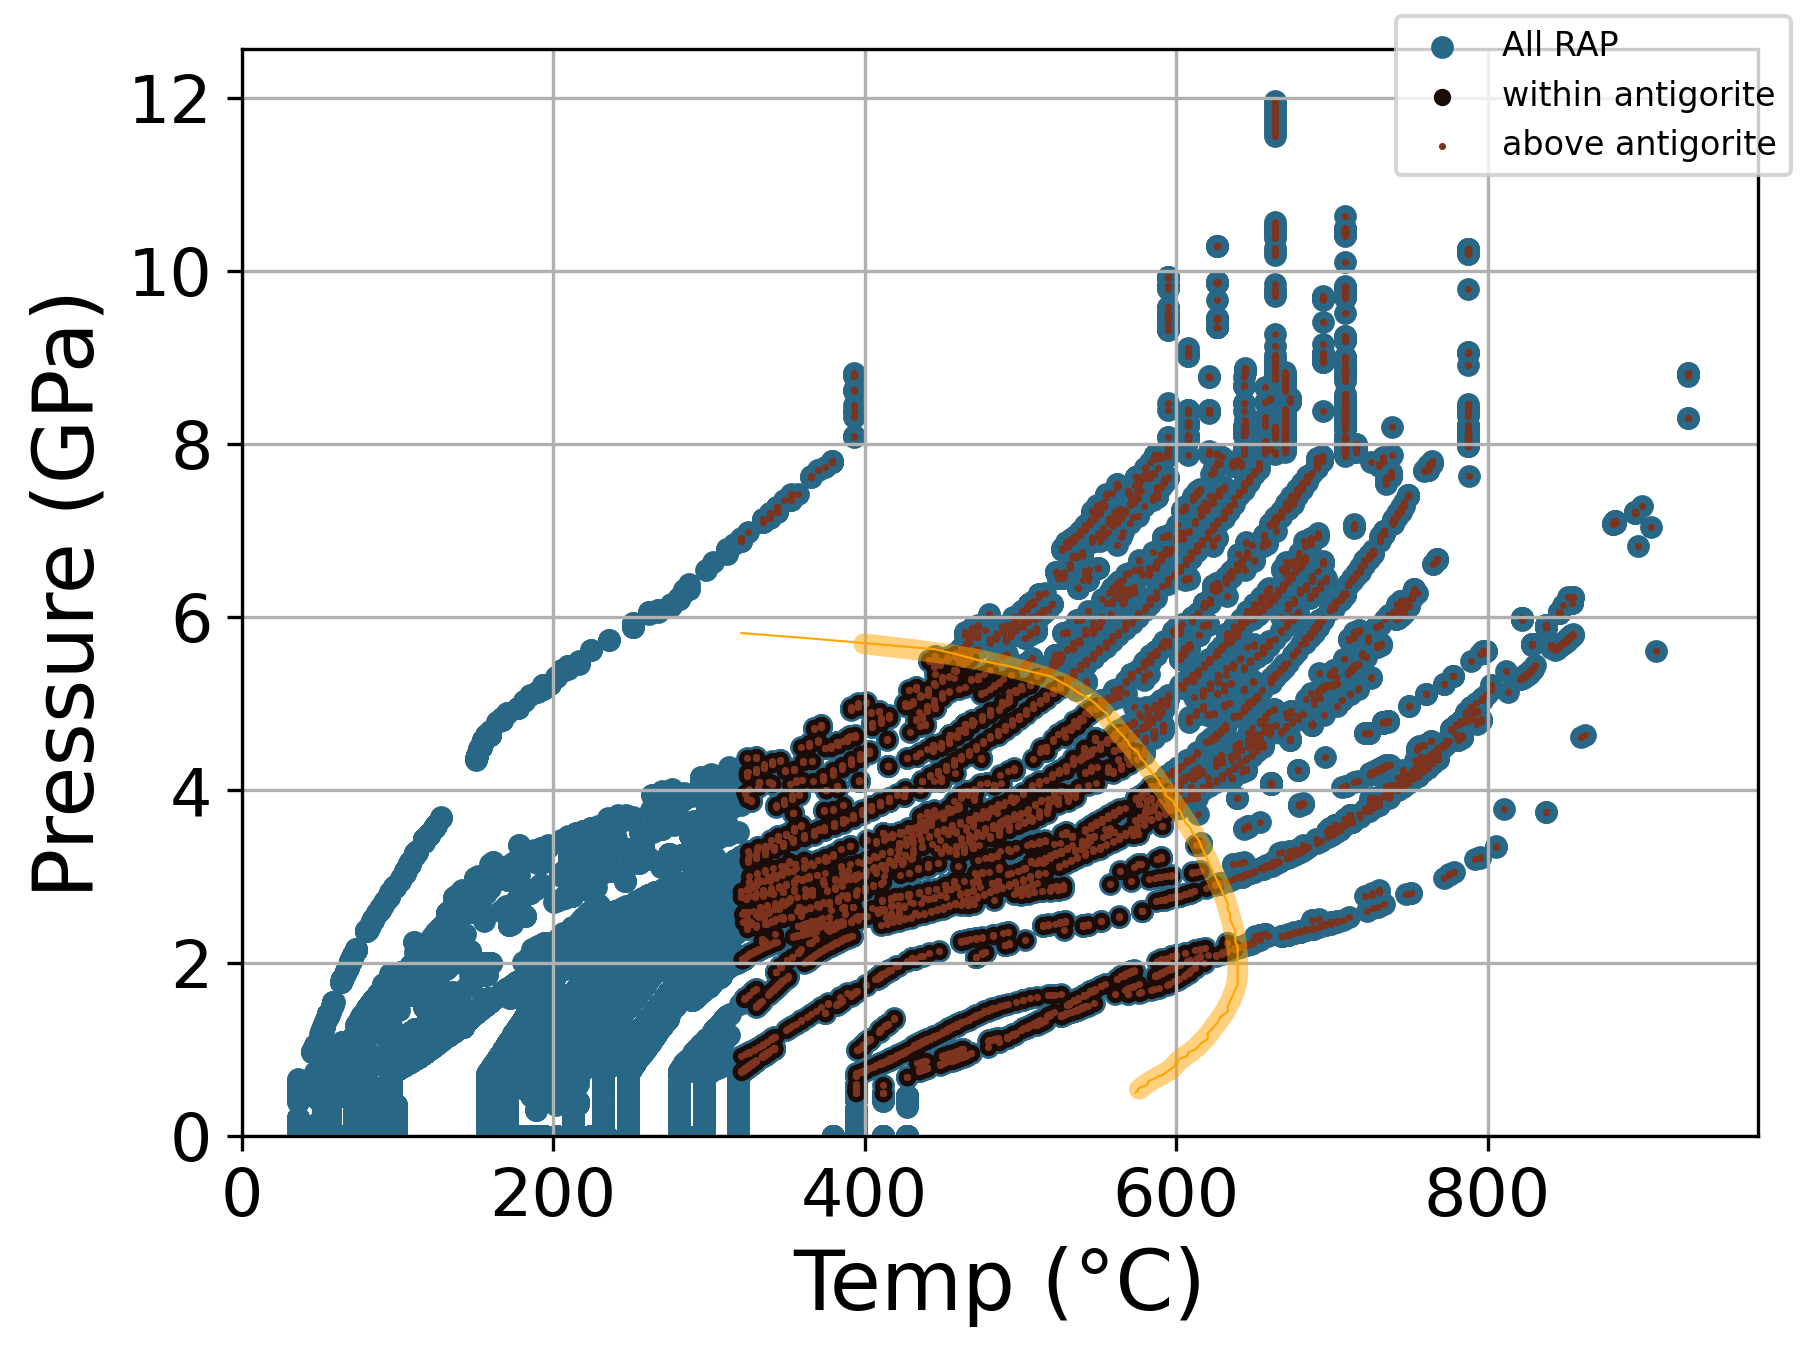

In [8]:
# Breakdown our results based on antigorite stability
df_above_min_antigorite_model = tracks[(tracks['temp_SYR10_MODEL'] >= min_ant_temp)
                                     & (tracks['pressure_MODEL'] >= min_ant_pressure)]


df_above_min_antigorite_slab2 = tracks[(tracks['temp_SYR10_SLAB2'] >= min_ant_temp)
                                     & (tracks['pressure_SLAB2'] >= min_ant_pressure)]

# Get points for bounding polygon
PT_path = np.dstack((antigorite_df['T_[C]'],antigorite_df['P_[kbar]']/10))[0]
nu_val = np.array([[antigorite_df['T_[C]'].min(),
                    antigorite_df['P_[kbar]'].min()/10
                    ]])
closed_PT_path = np.concatenate((PT_path, nu_val))
polygon_vertices = closed_PT_path

# Get PT points
pt_points_MODEL = np.dstack((df_above_min_antigorite_model['temp_SYR10_MODEL'], 
                              df_above_min_antigorite_model['pressure_MODEL']))[0]
pt_points_SLAB2 = np.dstack((df_above_min_antigorite_slab2['temp_SYR10_MODEL'], 
                              df_above_min_antigorite_slab2['pressure_MODEL']))[0]

# Check if each point is within the polygon
results_MODEL = [is_point_in_polygon(point, polygon_vertices) for point in pt_points_MODEL]
df_within_antigorite_model = df_above_min_antigorite_model[results_MODEL]
results_SLAB2 = [is_point_in_polygon(point, polygon_vertices) for point in pt_points_SLAB2]
df_within_antigorite_slab2 = df_above_min_antigorite_slab2[results_SLAB2]

#
# Now we have three dataframes,
# 1. df 'wtihin' antigorite stability
# 2. df that has passed within antigorite stability (and also left)
# 3. all subducted RAP    
#

cmap = cm.berlin
colors = cmap(np.linspace(0, 1, 5))

fig, ax = plt.subplots(nrows=1, 
                       ncols=1,
                       figsize=(6,4.5), dpi=300)
ax.scatter(tracks['temp_SYR10_MODEL'], 
           tracks['pressure_MODEL'], 
           c=colors[1], s=20, rasterized=True, label='All RAP')
ax.scatter(df_within_antigorite_model['temp_SYR10_MODEL'], 
           df_within_antigorite_model['pressure_MODEL'],
           c=colors[2], s=10, rasterized=True, label='within antigorite')
ax.scatter(df_above_min_antigorite_model['temp_SYR10_MODEL'], 
           df_above_min_antigorite_model['pressure_MODEL'],
           c=colors[3], s=0.5, rasterized=True, label='above antigorite')
ax.plot(antigorite_df['T_[C]'],antigorite_df['P_[kbar]']/10, c='orange', lw=0.5)
#ax.vlines(350, 0, 6, color='orange', lw=3, ls='--', alpha=0.5)
ax.plot(ant_temp_running_mean, ant_rho_running_mean, c='orange', lw=5, alpha=0.5)

ax.set_ylabel('Pressure (GPa)', fontsize=20)
ax.set_xlabel('Temp (°C)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlim(0)
ax.set_ylim(0)
ax.grid()
fig.legend()
fig.tight_layout()
#fig.savefig('./figures/all_RAP_PT_insert2.pdf')

In [9]:
# Get unique subzones, make a color dict if we want to plot that way
sub_zones = tracks['sub_zone_SYR10'].values
sub_zones_unique = np.unique(sub_zones)
#make color dict
cmap = cm.batlow
colors = cmap(np.linspace(0, 1, len(sub_zones_unique)))
colour_dict = dict(zip(sub_zones_unique, colors))


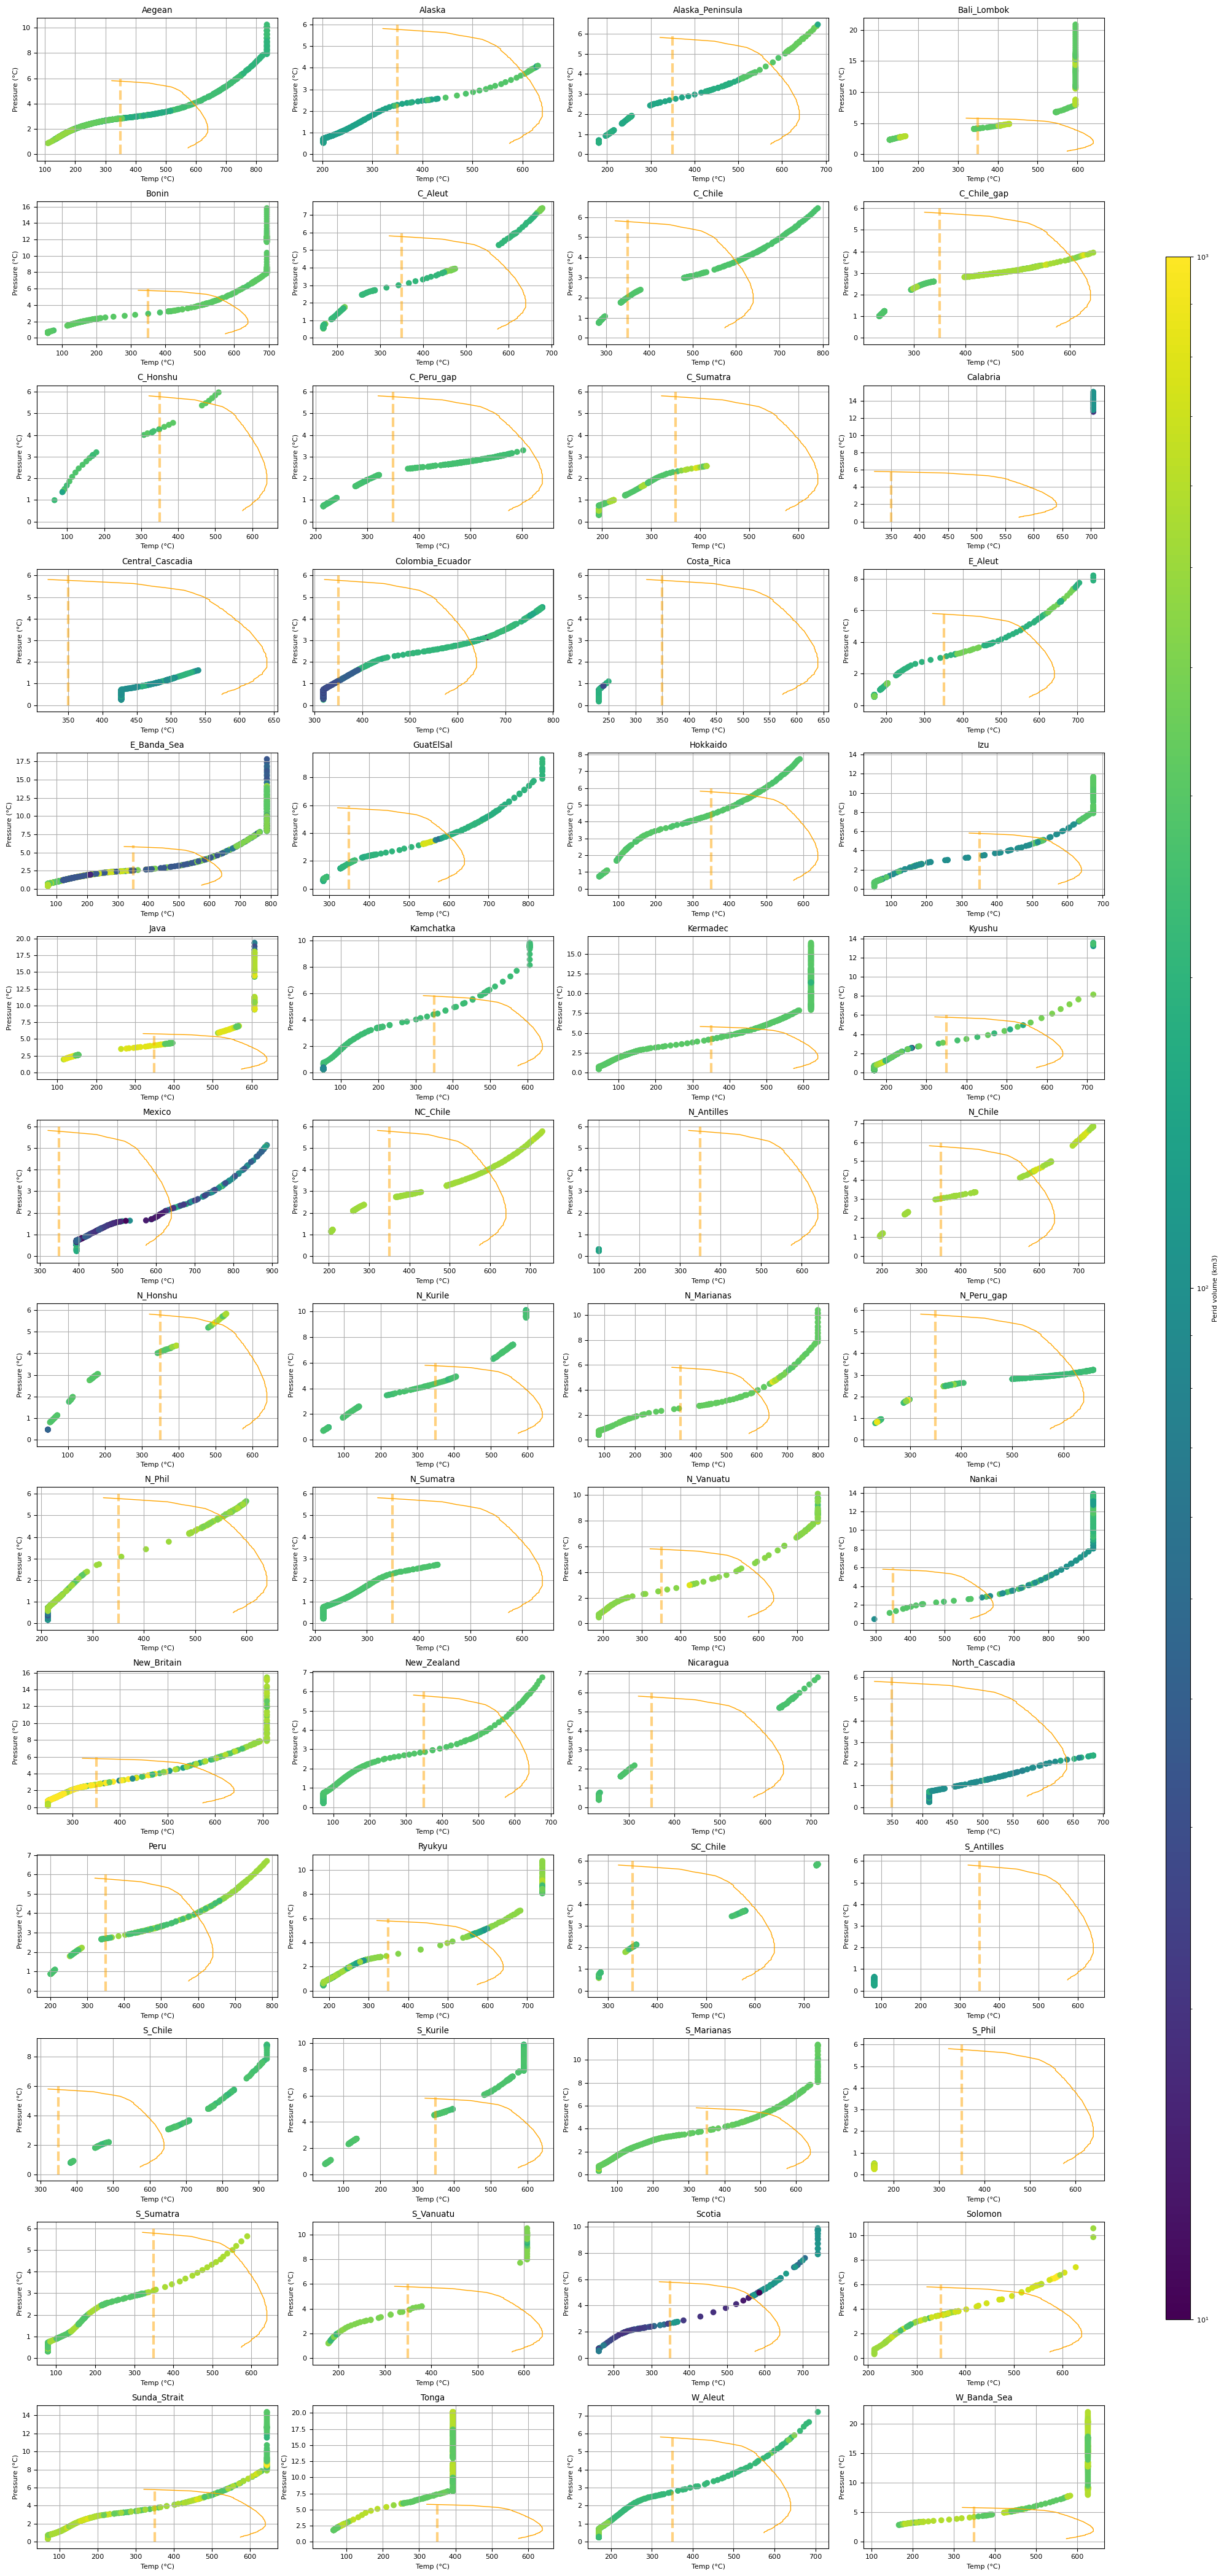

In [10]:
#make individual plots of all sub zones
rows = 14
cols = 4
fig, ax = plt.subplots(rows,cols, figsize=(20,42))

axes_count = [0,0]
sub_zone_index = 0
for row in range(rows):
    for col in range(cols):
        sub_zone = sub_zones_unique[sub_zone_index]
        #print(sub_zone_index, sub_zone)
        profile = tracks[tracks['sub_zone_SYR10'] == sub_zone]

        #sc = ax[row, col].scatter(profile['temp_SYR10_MODEL'],
        #                          profile['pressure_MODEL'],
        #                          c=profile['volume_perids'],
        #                          vmin=0.1, vmax=10000)#color=colour_dict[sub_zone])
        sc = ax[row, col].scatter(profile['temp_SYR10_SLAB2'],
                                  profile['pressure_SLAB2'],
                                  c=profile['volume_perids'],
                                  norm=mpl.colors.LogNorm( vmin=10, vmax=1000))#color=colour_dict[sub_zone])
        
        ax[row, col].plot(antigorite_df['T_[C]'], antigorite_df['P_[kbar]']/10, c='orange', lw=1)
        ax[row, col].vlines(350, 0, 6, color='orange', lw=3, ls='--', alpha=0.5)
        #ax[row, col].plot(ant_temp_running_mean, ant_rho_running_mean, c='orange', lw=1, alpha=0.5)
        ax[row, col].set_title(sub_zone)
        ax[row, col].set_xlabel('Temp (°C)')
        ax[row, col].set_ylabel('Pressure (°C)')
        #ax[row, col].set_xlim(0,650)
        #ax[row, col].set_ylim(0,6)        
        ax[row, col].grid(which='both')
        
        sub_zone_index += 1
fig.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
fig.colorbar(sc, cax=cbar_ax, orientation='vertical', label='Perid volume (km3)')

#fig.savefig('./isloated_sub_zones_perid.pdf')


In [11]:
# From Vitale Brovarone++ (2021) paper 0.2 kg of H2 per m3 of rock (given 1:1 
# water rock ratio producing a concentration of 10e-2 H2 per kg of reactant)
# so scaling up to per km3, we multiply by 1e9
H2_kg_per_m3 = np.asarray([0.09, 0.3])
H2_kg_per_km3 = H2_kg_per_m3 * 1e9  # h2 production per km3 of peridotite to react



In [22]:
# Calculations here of how much RAP there is
# Total RAP first

total_RAP_vol = np.sum(tracks['volume_perids'].values)
total_RAP_mass = perid_density_kg_km3 * total_RAP_vol
total_RAP_vol_per_annum = total_RAP_vol/1e6/5
total_RAP_mass_per_annum = total_RAP_mass/1e6/5

print('total_RAP_vol', '{:.1e}'.format(total_RAP_vol)) 
print('total_RAP_vol_per_annum', '{:.1e}'.format(total_RAP_vol_per_annum))
print('total_RAP_mass', '{:.1e}'.format(total_RAP_mass))
print('total_RAP_mass_per_annum', '{:.1e}'.format(total_RAP_mass_per_annum))

H2_kg = H2_kg_per_km3 * total_RAP_vol
H2_g = H2_kg * 1e3
H2_moles = H2_g/(1.00784*2)

print('total_H2_mass', [f'{val:.1e}' for val in H2_kg])
print('total_H2_mass_per_annum', [f'{val/1000000/5:.1e}' for val in H2_kg])
print('total_H2_moles', [f'{val:.1e}' for val in H2_moles])
print('total_H2_moles_per_annum', [f'{val/1000000/5:.1e}' for val in H2_moles])

results_dict['total_H2_mass'] = H2_kg
results_dict['total_H2_mass_per_annum'] = H2_kg/1000000/5
results_dict['total_H2_moles'] = H2_moles
results_dict['total_H2_moles_per_annum'] = H2_moles/1000000/5

total_RAP_vol 9.2e+06
total_RAP_vol_per_annum 1.8e+00
total_RAP_mass 3.0e+19
total_RAP_mass_per_annum 6.1e+12
total_H2_mass ['8.3e+14', '2.8e+15']
total_H2_mass_per_annum ['1.7e+08', '5.5e+08']
total_H2_moles ['4.1e+17', '1.4e+18']
total_H2_moles_per_annum ['8.2e+10', '2.7e+11']


In [25]:
# Calculations here of how much RAP there is
# Within antigorite stability field

antigorite_RAP_vol_model = np.sum(df_within_antigorite_model['volume_perids'].values)
antigorite_RAP_vol_slab2 = np.sum(df_within_antigorite_slab2['volume_perids'].values)

# sort arrays so we multiply small by small and big by big later one
antigorite_RAP_vols = np.sort(np.asarray([antigorite_RAP_vol_model, antigorite_RAP_vol_slab2]))
antigorite_RAP_mass = perid_density_kg_km3 * antigorite_RAP_vols
antigorite_RAP_vol_per_annum = antigorite_RAP_vols/1e6/5
antigorite_RAP_mass_per_annum = antigorite_RAP_mass/1e6/5

print('total_RAP_vol', antigorite_RAP_vols)
print('total_RAP_vol_per_annum', antigorite_RAP_vol_per_annum)
print('total_RAP_mass', antigorite_RAP_mass)
print('total_RAP_mass_per_annum', antigorite_RAP_mass_per_annum)

H2_kg = H2_kg_per_km3 * antigorite_RAP_vols
H2_g = H2_kg * 1e3
H2_moles = H2_g/(1.00784*2)

#
#print('total_H2_mass', H2_kg)
#print('total_H2_mass_per_annum', H2_kg/1000000/5)
#print('total_H2_moles', H2_moles)
#print('total_H2_moles_per_annum', H2_moles/1000000/5)

print('total_H2_mass', [f'{val:.1e}' for val in H2_kg])
print('total_H2_mass_per_annum', [f'{val/1000000/5:.1e}' for val in H2_kg])
print('total_H2_moles', [f'{val:.1e}' for val in H2_moles])
print('total_H2_moles_per_annum', [f'{val/1000000/5:.1e}' for val in H2_moles])

results_dict['within_RAP_H2_mass'] = H2_kg
results_dict['within_RAP_H2_mass_per_annum'] = H2_kg/1000000/5
results_dict['within_RAP_H2_moles'] = H2_moles
results_dict['within_RAP_H2_moles_per_annum'] = H2_moles/1000000/5

total_RAP_vol [ 684804.9844371  1809917.32214356]
total_RAP_vol_per_annum [0.136961   0.36198346]
total_RAP_mass [2.25985645e+18 5.97272716e+18]
total_RAP_mass_per_annum [4.51971290e+11 1.19454543e+12]
total_H2_mass ['6.2e+13', '5.4e+14']
total_H2_mass_per_annum ['1.2e+07', '1.1e+08']
total_H2_moles ['3.1e+16', '2.7e+17']
total_H2_moles_per_annum ['6.1e+09', '5.4e+10']


In [26]:
# Calculations here of how much RAP there is
# Above min antigorite stability field

above_antigorite_RAP_vol_model = np.sum(df_above_min_antigorite_model['volume_perids'].values)
above_antigorite_RAP_vol_slab2 = np.sum(df_above_min_antigorite_slab2['volume_perids'].values)

# sort arrays so we multiply small by small and big by big later one
above_antigorite_RAP_vols = np.sort(np.asarray([above_antigorite_RAP_vol_model, above_antigorite_RAP_vol_slab2]))
above_antigorite_RAP_mass = perid_density_kg_km3 * above_antigorite_RAP_vols
above_antigorite_RAP_vol_per_annum = above_antigorite_RAP_vols/1e6/5
above_antigorite_RAP_mass_per_annum = above_antigorite_RAP_mass/1e6/5

print('total_RAP_vol', above_antigorite_RAP_vols)
print('total_RAP_vol_per_annum', above_antigorite_RAP_vol_per_annum)
print('total_RAP_mass', above_antigorite_RAP_mass)
print('total_RAP_mass_per_annum', above_antigorite_RAP_mass_per_annum)

H2_kg = H2_kg_per_km3 * above_antigorite_RAP_vols
H2_g = H2_kg * 1e3
H2_moles = H2_g/(1.00784*2)

#
print('total_H2_mass', [f'{val:.1e}' for val in H2_kg])
print('total_H2_mass_per_annum', [f'{val/1000000/5:.1e}' for val in H2_kg])
print('total_H2_moles', [f'{val:.1e}' for val in H2_moles])
print('total_H2_moles_per_annum', [f'{val/1000000/5:.1e}' for val in H2_moles])

results_dict['above_min_RAP_H2_mass'] = H2_kg
results_dict['above_min_RAP_H2_mass_per_annum'] = H2_kg/1000000/5
results_dict['above_min_RAP_H2_moles'] = H2_moles
results_dict['above_min_RAP_H2_moles_per_annum'] = H2_moles/1000000/5

total_RAP_vol [2321441.42990867 4051378.32893884]
total_RAP_vol_per_annum [0.46428829 0.81027567]
total_RAP_mass [7.66075672e+18 1.33695485e+19]
total_RAP_mass_per_annum [1.53215134e+12 2.67390970e+12]
total_H2_mass ['2.1e+14', '1.2e+15']
total_H2_mass_per_annum ['4.2e+07', '2.4e+08']
total_H2_moles ['1.0e+17', '6.0e+17']
total_H2_moles_per_annum ['2.1e+10', '1.2e+11']


In [85]:
antigorite_RAP_vols/total_RAP_vol

array([0.07447157, 0.19682595])

In [49]:
above_antigorite_RAP_mass/total_RAP_mass

array([0.44058167, 0.25245347])

In [35]:
##how much h2 from vitale brovarone 2017: 1 mole of fosterite gives 0.08 moles of H2
#need total mass of peridotite
#check our work now
fosterite_MM = 140.691 #molar mass of fosterite
vol_of_RAP_VB17 = 0.21 #volume of RAP
total_mass_of_RAP_VB17 =  vol_of_RAP_VB17 * perid_density_g_km3
total_moles_of_RAP_VB17 = total_mass_of_RAP_VB17/fosterite_MM #* 0.08 * 2
total_moles_of_H2_VB17 = total_moles_of_RAP_VB17 * 0.08
total_mass_of_H2_VB17 = total_moles_of_H2_VB17 * 1.00784 * 2 #convert to grams of H2
total_mass_of_H2_VB17 * 1e-12 #in megatonnes

0.7942888969443674

In [16]:
# How much h2 from Vitale Brovarone 2017: 1 mole of fosterite gives 0.08 moles of H2
# Need total mass of peridotite

fosterite_MM = 140.691  # molar mass of fosterite
vol_of_RAP_MER22 = 1.8  # Volume of RAP subducted each year over the last 5 MA
total_mass_of_RAP_MER22 =  vol_of_RAP_MER22 * perid_density_g_km3
total_moles_of_RAP_MER22 = total_mass_of_RAP_MER22/fosterite_MM 
total_moles_of_H2_MER22 = total_moles_of_RAP_MER22 * 0.08
total_mass_of_H2_MER22 = total_moles_of_H2_MER22 * 1.00784 * 2  # convert to grams of H2
total_mass_of_H2_MER22 * 1e-12  # in megatonnes

6.808190545237435

In [17]:
#water going in from Volker et al. 2014
SZ_length = 1480*1000 #km to metres
terragram_H2O = 68 #per m per Ma of subduction
kilogram_H2O = terragram_H2O*1e9 #per m per Ma of subduction
total_H2O_kg = kilogram_H2O*SZ_length #total H2O along subduction zone
total_H2O_kg

#how much water is in the mantle wedge.
#syrcuse sections: Central Chile Gap, Central Chile, South-Central Chile, South Chile 
total_length = (640+500+490+360)*1e3
average_terragram_H2O_wedge = (640*1e3*448)/total_length + (686*500*1e3)/total_length + (490*1e3*735)/total_length + (795*360*1e3)/total_length
total_kilogram_H2O_wedge = average_terragram_H2O_wedge*1480*1e9

total_kilogram_H2O_wedge

949036984924623.0

In [18]:
lower_VB2020_MT_a = 9e-3
upper_VB2020_MT_a = 0.3
lower_VB2020_kg_a = lower_VB2020_MT_a * 1e9
upper_VB2020_kg_a = upper_VB2020_MT_a * 1e9

In [84]:
# Convert to Vitale Brovarone et al. 2020 mantle wedge calculation
# we will use the total amount of RAP past min antigorite stability over last 5 Ma
# 15wt%
total_water_in_antigorite_kg = 0.15 * perid_density_kg_km3 * above_antigorite_RAP_vols
total_water_to_react_kg3 = total_water_in_antigorite_kg
total_perid_to_react = total_water_to_react_kg3
# Assumes:
# 1:1 fluid:rock
upper_value_moles = 4e-2 # mol 
lower_value_moles = 1.5e-3 # mol
upper_value_kg = 4e-2 * 1.00784 * 2 / 1000
lower_value_kg = 1.5e-3 * 1.00784 * 2 / 1000
upper_total_H2_kg = upper_value_kg * total_perid_to_react
lower_total_H2_kg = lower_value_kg * total_perid_to_react
upper_total_H2_MT = upper_total_H2_kg / 1000000000
lower_total_H2_MT = lower_total_H2_kg / 1000000000
upper_total_H2_moles = upper_value_moles * total_perid_to_react
lower_total_H2_moles = lower_value_moles * total_perid_to_react
print('water (kg)',total_water_to_react_kg3)
print('upper H2 (kg per 5 Ma)', upper_total_H2_kg)
print('lower H2 (kg per 5 Ma)', lower_total_H2_kg)
print('upper H2 (MT per 5 Ma)', upper_total_H2_MT)
print('lower H2 (MT per 5 Ma)', lower_total_H2_MT)
print('upper H2 (kg per a)', upper_total_H2_kg/1000000/5)
print('lower H2 (kg per a)', lower_total_H2_kg/1000000/5)
print('upper H2 (MT per a)', upper_total_H2_MT/1000000/5)
print('lower H2 (MT per a)', lower_total_H2_MT/1000000/5)

water (kg) [1.14911351e+18 2.00543227e+18]
upper H2 (kg per 5 Ma) [9.26498046e+13 1.61692389e+14]
lower H2 (kg per 5 Ma) [3.47436767e+12 6.06346459e+12]
upper H2 (MT per 5 Ma) [ 92649.80461648 161692.38894749]
lower H2 (MT per 5 Ma) [3474.36767312 6063.46458553]
upper H2 (kg per a) [18529960.92329572 32338477.78949878]
lower H2 (kg per a) [ 694873.53462359 1212692.9171062 ]
upper H2 (MT per a) [0.01852996 0.03233848]
lower H2 (MT per a) [0.00069487 0.00121269]


In [ ]:
# Mantle hydration Faccenda
conv_area = 2.7 #km2
min_penetration = 5
max_penetration = 10

# In km3
mantle_perid_volume_min = conv_area*min_penetration
mantle_perid_volume_max = conv_area*max_penetration
print(mantle_perid_volume_min, mantle_perid_volume_max)
# To hydrogen (0.2 kg per m3 of peridotite)
mantle_H2_total_kg = np.asarray([mantle_perid_volume_min, mantle_perid_volume_max]) * H2_kg_per_km3
mantle_H2_total_kg


In [ ]:
# Review comment
h2_g_per_kg = 0.02 
h2_g_per_m3 = h2_g_per_kg * perid_density_g_m3
h2_g_per_m3 * 1e-3

H2_kg_per_m3 = 0.2
H2_kg_per_kg = H2_kg_per_m3/perid_density_kg_m3
H2_kg_per_kg *1e3
